# Обнаружение вредителей по аудио-сигналам

## Задача: Бинарная классификация (есть вредитель / нет)

### Модели:
- 1D-CNN для обработки raw-сигналов
- Transformer для временных рядов

### Требования:
- Применение спектрограмм или raw-сигналов
- Кросс-валидация
- Обоснование выбора архитектуры

## 1. Импорт библиотек

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve)
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Установка seed для воспроизводимости
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")

## 2. Загрузка и анализ данных

In [2]:
# Загрузка данных
df = pd.read_csv('../data/raw/pest_audio_detection_dataset.csv')

print(f"Размер датасета: {df.shape}")
print(f"\nКолонки: {df.columns.tolist()}")
print(f"\nПервые 5 строк:")
df.head()

Размер датасета: (2000, 261)

Колонки: ['sample_id', 'spectral_centroid', 'spectral_energy', 'zero_crossing_rate', 'label_pest_present', 'signal_0', 'signal_1', 'signal_2', 'signal_3', 'signal_4', 'signal_5', 'signal_6', 'signal_7', 'signal_8', 'signal_9', 'signal_10', 'signal_11', 'signal_12', 'signal_13', 'signal_14', 'signal_15', 'signal_16', 'signal_17', 'signal_18', 'signal_19', 'signal_20', 'signal_21', 'signal_22', 'signal_23', 'signal_24', 'signal_25', 'signal_26', 'signal_27', 'signal_28', 'signal_29', 'signal_30', 'signal_31', 'signal_32', 'signal_33', 'signal_34', 'signal_35', 'signal_36', 'signal_37', 'signal_38', 'signal_39', 'signal_40', 'signal_41', 'signal_42', 'signal_43', 'signal_44', 'signal_45', 'signal_46', 'signal_47', 'signal_48', 'signal_49', 'signal_50', 'signal_51', 'signal_52', 'signal_53', 'signal_54', 'signal_55', 'signal_56', 'signal_57', 'signal_58', 'signal_59', 'signal_60', 'signal_61', 'signal_62', 'signal_63', 'signal_64', 'signal_65', 'signal_66', 's

,sample_id,spectral_centroid,spectral_energy,zero_crossing_rate,label_pest_present,signal_0,signal_1,signal_2,signal_3,signal_4,...,signal_246,signal_247,signal_248,signal_249,signal_250,signal_251,signal_252,signal_253,signal_254,signal_255
0,0,65.8902,8206.6614,0.5234,0,-0.27512,0.25772,0.23693,0.68423,-0.45841,...,-0.18726,-0.64561,-0.38275,0.21116,-0.65396,-0.99530,-0.42877,0.42000,0.89065,-0.33871
1,1,64.0523,8656.8250,0.4453,0,-0.16712,-0.15892,0.15888,-0.80611,0.47269,...,-0.19403,-0.33420,0.69787,-0.65482,-0.95689,0.47064,0.01385,0.06368,-0.18071,-0.11925
2,2,58.5803,74913.2219,0.3164,1,-0.31230,0.17212,2.39415,0.76035,-0.69763,...,-1.14845,-2.96394,-0.89243,-0.06224,1.98288,1.27915,-0.44245,-2.12654,-2.82482,0.44338
3,3,59.6419,73728.7258,0.3086,1,0.14956,0.88956,1.34588,-0.36519,-1.45689,...,-0.41814,-2.28188,0.06875,0.88962,1.95651,0.96233,-0.19801,-2.02459,-1.54713,-0.09610
4,4,57.7770,74708.7445,0.3125,1,-0.31729,1.51342,1.82053,-0.06250,-1.69908,...,-0.53570,-2.10600,-0.71932,0.64395,1.70208,1.51037,-0.64592,-1.86400,-1.20861,-0.01206


In [4]:
# Анализ целевой переменной
print("Распределение классов:")
print(df['label_pest_present'].value_counts())
print(f"\nПроцентное соотношение:")
print(df['label_pest_present'].value_counts(normalize=True) * 100)

Распределение классов:
label_pest_present
0    1008
1     992
Name: count, dtype: int64

Процентное соотношение:
label_pest_present
0    50.4
1    49.6
Name: proportion, dtype: float64


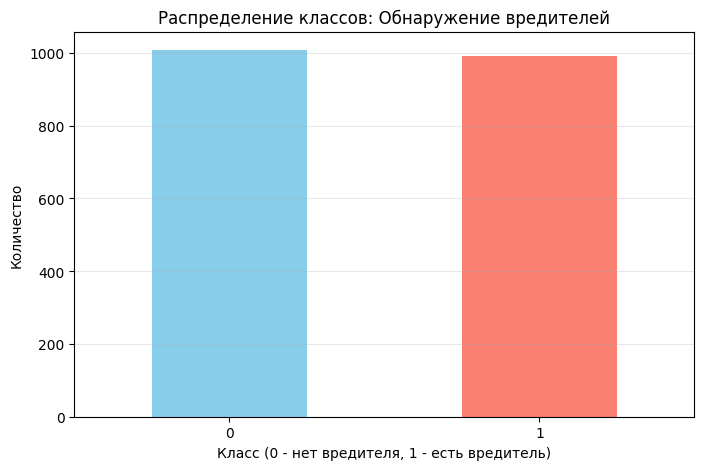

In [6]:
# Визуализация распределения классов
plt.figure(figsize=(8, 5))
df['label_pest_present'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Распределение классов: Обнаружение вредителей')
plt.xlabel('Класс (0 - нет вредителя, 1 - есть вредитель)')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

## 3. Подготовка данных

In [8]:
# Определение признаков и целевой переменной
feature_cols = [col for col in df.columns if col.startswith('signal_')]
print(f"Количество аудио признаков: {len(feature_cols)}")

X = df[feature_cols].values
y = df['label_pest_present'].values

print(f"Форма X: {X.shape}")
print(f"Форма y: {y.shape}")

Количество аудио признаков: 256
Форма X: (2000, 256)
Форма y: (2000,)


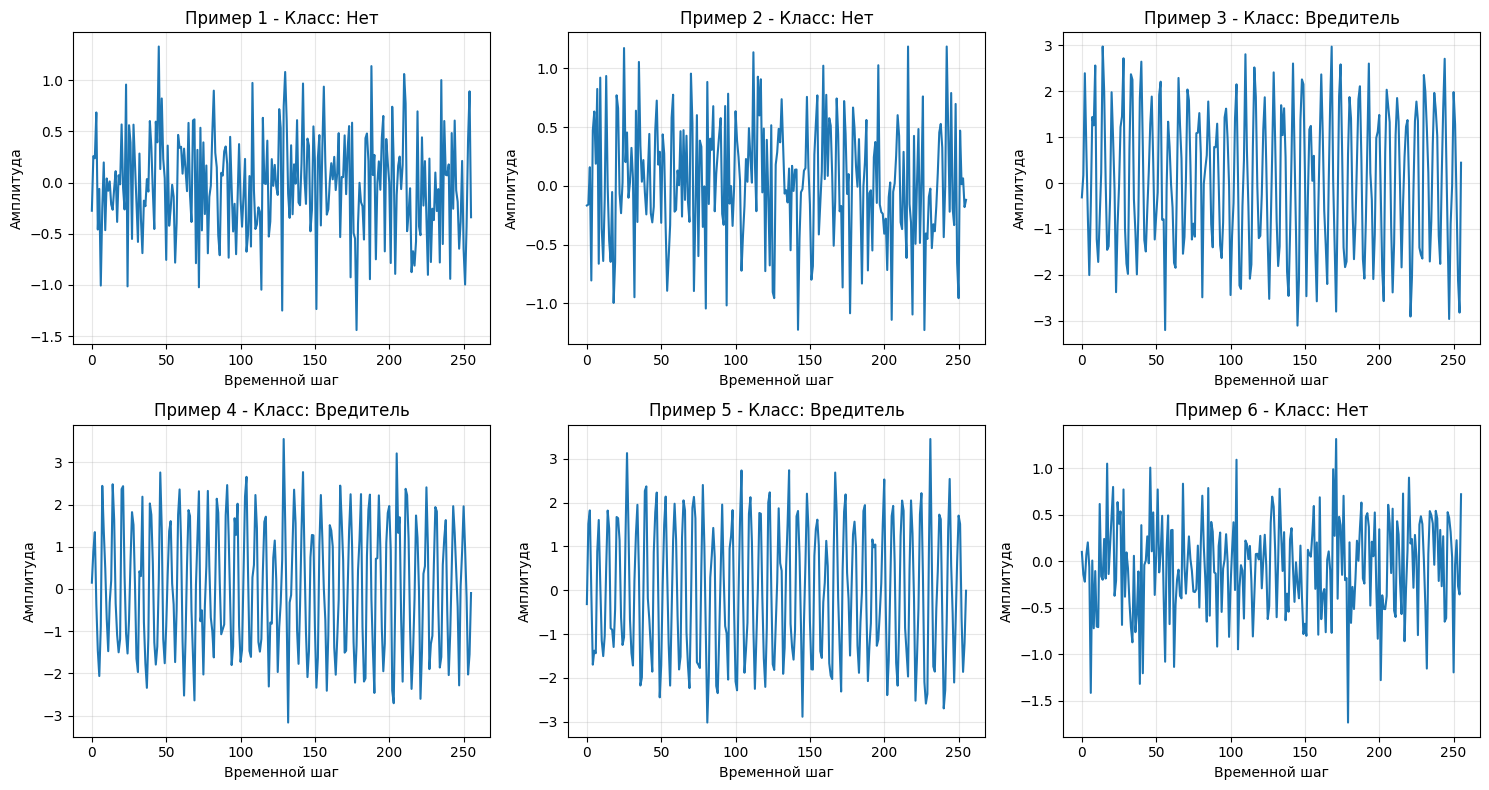

In [9]:
# Визуализация примеров аудио-сигналов
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for idx, ax in enumerate(axes.flat):
    sample = X[idx]
    label = y[idx]
    ax.plot(sample)
    ax.set_title(f'Пример {idx+1} - Класс: {"Вредитель" if label == 1 else "Нет"}')
    ax.set_xlabel('Временной шаг')
    ax.set_ylabel('Амплитуда')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
# Нормализация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape для 1D-CNN (samples, timesteps, channels)
X_cnn = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)
print(f"Форма для CNN: {X_cnn.shape}")

Форма для CNN: (2000, 256, 1)


## 4. Создание спектрограмм

In [11]:
def create_spectrogram(signal, n_fft=64, hop_length=16):
    """
    Создание спектрограммы из аудио-сигнала
    """
    # Применение STFT
    stft = tf.signal.stft(
        signal,
        frame_length=n_fft,
        frame_step=hop_length,
        fft_length=n_fft
    )
    # Получение амплитуды
    spectrogram = tf.abs(stft)
    # Преобразование в децибелы
    spectrogram = tf.math.log(spectrogram + 1e-10)
    return spectrogram

# Пример создания спектрограммы
sample_signal = X_scaled[0].astype(np.float32)
spec = create_spectrogram(sample_signal)
print(f"Форма спектрограммы: {spec.shape}")

Форма спектрограммы: (13, 33)


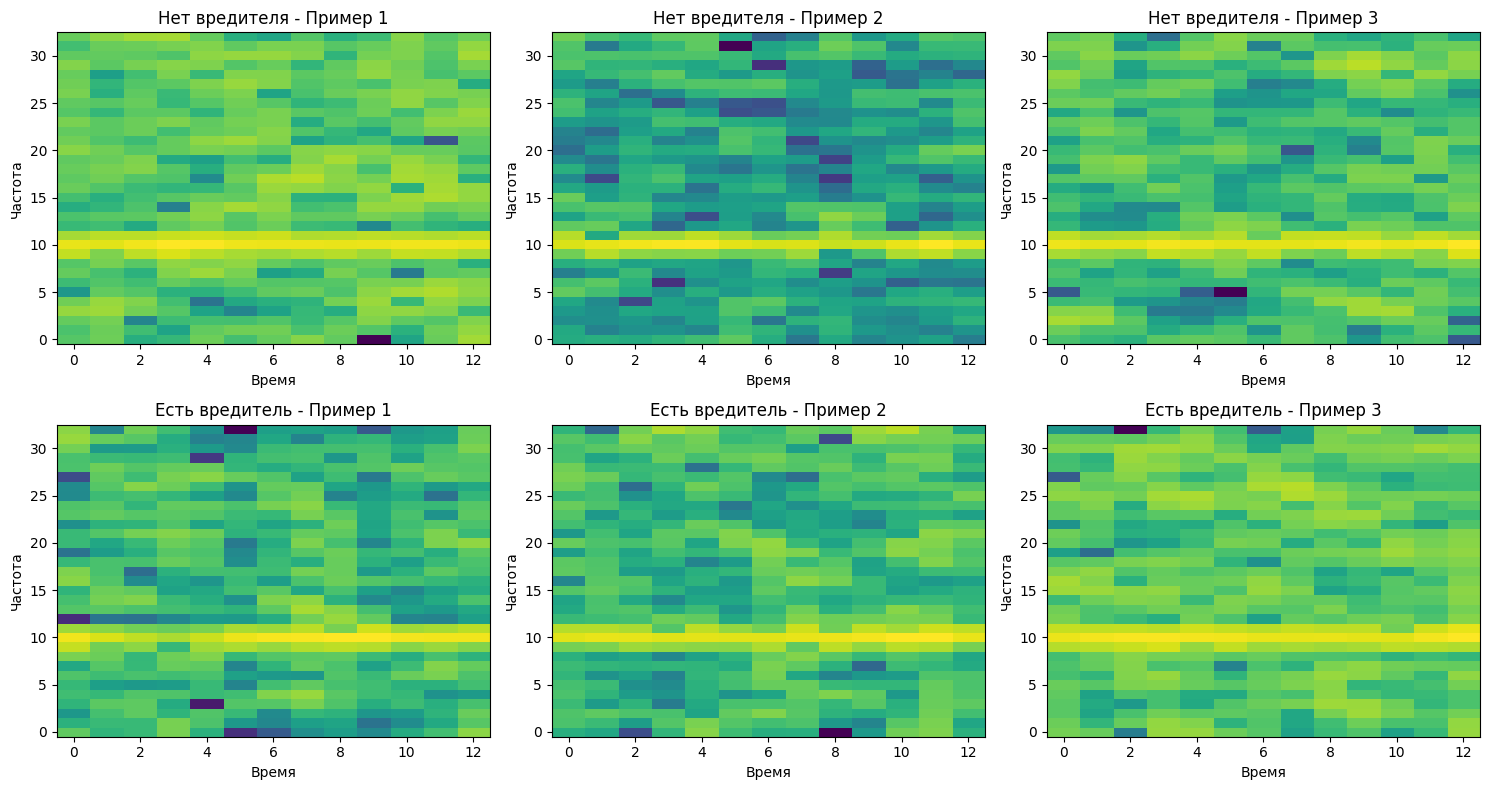

In [12]:
# Визуализация спектрограмм для разных классов
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

pest_indices = np.where(y == 1)[0][:3]
no_pest_indices = np.where(y == 0)[0][:3]

for idx, ax in enumerate(axes[0]):
    signal = X_scaled[no_pest_indices[idx]].astype(np.float32)
    spec = create_spectrogram(signal)
    im = ax.imshow(spec.numpy().T, aspect='auto', origin='lower', cmap='viridis')
    ax.set_title(f'Нет вредителя - Пример {idx+1}')
    ax.set_xlabel('Время')
    ax.set_ylabel('Частота')

for idx, ax in enumerate(axes[1]):
    signal = X_scaled[pest_indices[idx]].astype(np.float32)
    spec = create_spectrogram(signal)
    im = ax.imshow(spec.numpy().T, aspect='auto', origin='lower', cmap='viridis')
    ax.set_title(f'Есть вредитель - Пример {idx+1}')
    ax.set_xlabel('Время')
    ax.set_ylabel('Частота')

plt.tight_layout()
plt.show()

## 5. Архитектура 1D-CNN для Raw-сигналов

### Обоснование:
- **1D-CNN** эффективно извлекает локальные паттерны из временных рядов
- Использование свёрточных слоёв позволяет автоматически извлекать признаки разных масштабов
- Batch Normalization ускоряет обучение и стабилизирует градиенты
- Global Average Pooling уменьшает количество параметров и предотвращает переобучение

In [13]:
def build_1d_cnn(input_shape, num_classes=1):
    """
    1D-CNN модель для классификации аудио-сигналов
    """
    inputs = layers.Input(shape=input_shape)
    
    # Блок 1
    x = layers.Conv1D(64, kernel_size=7, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(0.2)(x)
    
    # Блок 2
    x = layers.Conv1D(128, kernel_size=5, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(0.2)(x)
    
    # Блок 3
    x = layers.Conv1D(256, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.3)(x)
    
    # Полносвязные слои
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    return model

# Создание модели
cnn_model = build_1d_cnn((X_cnn.shape[1], 1))
cnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 256, 64)             │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 256, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 128, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 128, 128)            │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 128, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 64, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 64, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 64, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 174,977 (683.50 KB)

 Trainable params: 174,081 (680.00 KB)

 Non-trainable params: 896 (3.50 KB)

## 6. Архитектура Transformer для временных рядов

### Обоснование:
- **Transformer** использует механизм self-attention для захвата долгосрочных зависимостей
- Позиционное кодирование сохраняет временную информацию
- Multi-head attention позволяет модели фокусироваться на разных аспектах сигнала
- Эффективен для последовательностей с сложными временными паттернами

In [14]:
class PositionalEncoding(layers.Layer):
    """
    Позиционное кодирование для Transformer
    """
    def __init__(self, max_len=5000, **kwargs):
        super().__init__(**kwargs)
        self.max_len = max_len
    
    def build(self, input_shape):
        d_model = input_shape[-1]
        positions = np.arange(self.max_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        
        pe = np.zeros((self.max_len, d_model))
        pe[:, 0::2] = np.sin(positions * div_term)
        pe[:, 1::2] = np.cos(positions * div_term)
        
        self.pe = tf.constant(pe[np.newaxis, ...], dtype=tf.float32)
        super().build(input_shape)
    
    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]
        return inputs + self.pe[:, :seq_len, :]
    
    def get_config(self):
        config = super().get_config()
        config.update({'max_len': self.max_len})
        return config

def build_transformer(input_shape, num_classes=1, d_model=128, num_heads=4, 
                      ff_dim=256, num_transformer_blocks=2):
    """
    Transformer модель для классификации временных рядов
    """
    inputs = layers.Input(shape=input_shape)
    
    # Проекция в d_model размерность
    x = layers.Conv1D(d_model, kernel_size=1, padding='same')(inputs)
    x = PositionalEncoding()(x)
    
    # Transformer блоки
    for _ in range(num_transformer_blocks):
        # Multi-head attention
        attn_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=d_model//num_heads
        )(x, x)
        x = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)
        
        # Feed-forward network
        ff_output = layers.Conv1D(ff_dim, kernel_size=1, activation='relu')(x)
        ff_output = layers.Conv1D(d_model, kernel_size=1)(ff_output)
        x = layers.LayerNormalization(epsilon=1e-6)(x + ff_output)
    
    # Global pooling и классификация
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    return model

# Создание модели
transformer_model = build_transformer((X_cnn.shape[1], 1))
transformer_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 256, 1)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_3 (Conv1D)             │ (None, 256, 128)          │             256 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ positional_encoding           │ (None, 256, 128)          │               0 │ conv1d_3[0][0]             │
│ (PositionalEncoding)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention          │ (None, 256, 128)          │          66,048 │ positional_encoding[0][0], │
│ (MultiHeadAttention)          │                           │                 │ positional_encoding[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 256, 128)          │               0 │ positional_encoding[0][0], │
│                               │                           │                 │ multi_head_attention[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization           │ (None, 256, 128)          │             256 │ add[0][0]                  │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_4 (Conv1D)             │ (None, 256, 256)          │          33,024 │ layer_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_5 (Conv1D)             │ (None, 256, 128)          │          32,896 │ conv1d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_1 (Add)                   │ (None, 256, 128)          │               0 │ layer_normalization[0][0], │
│                               │                           │                 │ conv1d_5[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_1         │ (None, 256, 128)          │             256 │ add_1[0][0]                │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_1        │ (None, 256, 128)          │          66,048 │ layer_normalization_1[0][… │
│ (MultiHeadAttention)          │                           │                 │ layer_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_2 (Add)                   │ (None, 256, 128)          │               0 │ layer_normalization_1[0][… │
│                               │                           │                 │ multi_head_attention_1[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_2         │ (None, 256, 128)          │             256 │ add_2[0][0]                │
│ (LayerNormalization)          │                           │               

 Total params: 273,537 (1.04 MB)

 Trainable params: 273,537 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

## 7. Кросс-валидация и обучение моделей

In [1]:
def evaluate_model(model, X_test, y_test, model_name):
    """
    Оценка модели и вывод метрик
    """
    y_pred_prob = model.predict(X_test, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_prob)
    }
    
    print(f"\n=== {model_name} ===")
    for metric, value in metrics.items():
        print(f"{metric.upper()}: {value:.4f}")
    
    return metrics, y_pred, y_pred_prob

def plot_training_history(history, model_name):
    """
    Визуализация истории обучения
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Loss
    axes[0].plot(history.history['loss'], label='Train')
    axes[0].plot(history.history['val_loss'], label='Validation')
    axes[0].set_title(f'{model_name} - Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Accuracy
    axes[1].plot(history.history['accuracy'], label='Train')
    axes[1].plot(history.history['val_accuracy'], label='Validation')
    axes[1].set_title(f'{model_name} - Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, model_name):
    """
    Визуализация матрицы ошибок
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Нет', 'Есть'], 
                yticklabels=['Нет', 'Есть'])
    plt.title(f'{model_name} - Матрица ошибок')
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')
    plt.show()

def plot_roc_curves(results):
    """
    Визуализация ROC-кривых для всех моделей
    """
    plt.figure(figsize=(8, 6))
    
    for model_name, (_, y_test, y_pred_prob) in results.items():
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        auc = roc_auc_score(y_test, y_pred_prob)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

In [ ]:
# Параметры кросс-валидации
N_SPLITS = 5
EPOCHS = 50
BATCH_SIZE = 32

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

lr_reducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7
)

### 7.1 Кросс-валидация 1D-CNN

In [ ]:
# Stratified K-Fold для сохранения баланса классов
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

cnn_cv_scores = []
cnn_histories = []
fold = 1

print("=== Кросс-валидация 1D-CNN ===")

for train_idx, val_idx in skf.split(X_cnn, y):
    print(f"\nFold {fold}/{N_SPLITS}")
    
    X_train_fold, X_val_fold = X_cnn[train_idx], X_cnn[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]
    
    # Создание модели
    model = build_1d_cnn((X_cnn.shape[1], 1))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Обучение
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stopping, lr_reducer],
        verbose=0
    )
    
    # Оценка
    val_loss, val_acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    cnn_cv_scores.append(val_acc)
    cnn_histories.append(history)
    
    print(f"Validation Accuracy: {val_acc:.4f}")
    fold += 1

print(f"\n=== Результаты кросс-валидации 1D-CNN ===")
print(f"Mean Accuracy: {np.mean(cnn_cv_scores):.4f} (+/- {np.std(cnn_cv_scores):.4f})")

In [ ]:
# Визуализация истории обучения для всех фолдов
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, history in enumerate(cnn_histories):
    axes[i].plot(history.history['accuracy'], label='Train')
    axes[i].plot(history.history['val_accuracy'], label='Val')
    axes[i].set_title(f'Fold {i+1}')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Accuracy')
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.suptitle('1D-CNN: Accuracy по фолдам')
plt.tight_layout()
plt.show()

### 7.2 Кросс-валидация Transformer

In [ ]:
transformer_cv_scores = []
transformer_histories = []
fold = 1

print("=== Кросс-валидация Transformer ===")

for train_idx, val_idx in skf.split(X_cnn, y):
    print(f"\nFold {fold}/{N_SPLITS}")
    
    X_train_fold, X_val_fold = X_cnn[train_idx], X_cnn[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]
    
    # Создание модели
    model = build_transformer((X_cnn.shape[1], 1))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Обучение
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stopping, lr_reducer],
        verbose=0
    )
    
    # Оценка
    val_loss, val_acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    transformer_cv_scores.append(val_acc)
    transformer_histories.append(history)
    
    print(f"Validation Accuracy: {val_acc:.4f}")
    fold += 1

print(f"\n=== Результаты кросс-валидации Transformer ===")
print(f"Mean Accuracy: {np.mean(transformer_cv_scores):.4f} (+/- {np.std(transformer_cv_scores):.4f})")

In [ ]:
# Визуализация истории обучения для всех фолдов
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, history in enumerate(transformer_histories):
    axes[i].plot(history.history['accuracy'], label='Train')
    axes[i].plot(history.history['val_accuracy'], label='Val')
    axes[i].set_title(f'Fold {i+1}')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Accuracy')
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.suptitle('Transformer: Accuracy по фолдам')
plt.tight_layout()
plt.show()

## 8. Финальное обучение и сравнение моделей

In [ ]:
# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_cnn, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train size: {X_train.shape[0]}")
print(f"Test size: {X_test.shape[0]}")

In [ ]:
# Обучение финальной 1D-CNN
print("=== Обучение финальной 1D-CNN ===")

cnn_final = build_1d_cnn((X_cnn.shape[1], 1))
cnn_final.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

cnn_history = cnn_final.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, lr_reducer],
    verbose=1
)

plot_training_history(cnn_history, '1D-CNN')

In [ ]:
# Обучение финального Transformer
print("\n=== Обучение финального Transformer ===")

transformer_final = build_transformer((X_cnn.shape[1], 1))
transformer_final.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

transformer_history = transformer_final.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, lr_reducer],
    verbose=1
)

plot_training_history(transformer_history, 'Transformer')

## 9. Оценка и сравнение моделей

In [ ]:
# Оценка моделей
results = {}

cnn_metrics, cnn_pred, cnn_pred_prob = evaluate_model(cnn_final, X_test, y_test, '1D-CNN')
results['1D-CNN'] = (cnn_metrics, y_test, cnn_pred_prob)

transformer_metrics, transformer_pred, transformer_pred_prob = evaluate_model(
    transformer_final, X_test, y_test, 'Transformer'
)
results['Transformer'] = (transformer_metrics, y_test, transformer_pred_prob)

In [ ]:
# Сравнительная таблица метрик
comparison_df = pd.DataFrame({
    '1D-CNN': cnn_metrics,
    'Transformer': transformer_metrics
}).T

print("\n=== Сравнение моделей ===")
print(comparison_df.round(4))

In [ ]:
# Визуализация сравнения метрик
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

metrics_names = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

for idx, metric in enumerate(metrics_names):
    values = [cnn_metrics[metric], transformer_metrics[metric]]
    axes[idx].bar(['1D-CNN', 'Transformer'], values, color=['skyblue', 'salmon'])
    axes[idx].set_title(metric.upper())
    axes[idx].set_ylim(0, 1)
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Добавление значений на столбцы
    for i, v in enumerate(values):
        axes[idx].text(i, v + 0.02, f'{v:.3f}', ha='center')

# Удаление пустого subplot
axes[5].axis('off')

plt.suptitle('Сравнение метрик моделей')
plt.tight_layout()
plt.show()

In [ ]:
# Матрицы ошибок
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1D-CNN
cm_cnn = confusion_matrix(y_test, cnn_pred)
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Нет', 'Есть'], yticklabels=['Нет', 'Есть'])
axes[0].set_title('1D-CNN - Матрица ошибок')
axes[0].set_xlabel('Предсказанный класс')
axes[0].set_ylabel('Истинный класс')

# Transformer
cm_transformer = confusion_matrix(y_test, transformer_pred)
sns.heatmap(cm_transformer, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Нет', 'Есть'], yticklabels=['Нет', 'Есть'])
axes[1].set_title('Transformer - Матрица ошибок')
axes[1].set_xlabel('Предсказанный класс')
axes[1].set_ylabel('Истинный класс')

plt.tight_layout()
plt.show()

In [ ]:
# ROC-кривые
plt.figure(figsize=(8, 6))

fpr_cnn, tpr_cnn, _ = roc_curve(y_test, cnn_pred_prob)
auc_cnn = roc_auc_score(y_test, cnn_pred_prob)
plt.plot(fpr_cnn, tpr_cnn, label=f'1D-CNN (AUC = {auc_cnn:.3f})')

fpr_trans, tpr_trans, _ = roc_curve(y_test, transformer_pred_prob)
auc_trans = roc_auc_score(y_test, transformer_pred_prob)
plt.plot(fpr_trans, tpr_trans, label=f'Transformer (AUC = {auc_trans:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 10. Анализ важности признаков (для 1D-CNN)

In [ ]:
# Получение активаций первого свёрточного слоя
layer_name = cnn_final.layers[1].name  # Первый Conv1D
activation_model = Model(inputs=cnn_final.input, 
                         outputs=cnn_final.get_layer(layer_name).output)

# Активации для тестовых данных
activations = activation_model.predict(X_test[:10], verbose=0)

# Визуализация активаций
fig, axes = plt.subplots(2, 5, figsize=(20, 6))
axes = axes.flatten()

for i in range(10):
    # Усреднение по каналам
    mean_activation = np.mean(activations[i], axis=1)
    axes[i].plot(mean_activation)
    axes[i].set_title(f'Sample {i+1} (Class: {y_test[i]})')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Activation')
    axes[i].grid(alpha=0.3)

plt.suptitle('Активации первого свёрточного слоя 1D-CNN')
plt.tight_layout()
plt.show()

## 11. Сохранение моделей

In [ ]:
# Сохранение моделей
import os

models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)

# Сохранение 1D-CNN
cnn_final.save(f'{models_dir}/pest_detection_1d_cnn.h5')
print("1D-CNN модель сохранена")

# Сохранение Transformer
transformer_final.save(f'{models_dir}/pest_detection_transformer.h5')
print("Transformer модель сохранена")

# Сохранение scaler
import joblib
joblib.dump(scaler, f'{models_dir}/pest_detection_scaler.pkl')
print("Scaler сохранён")

## 12. Выводы

### Сравнение архитектур:

**1D-CNN:**
- Эффективно извлекает локальные паттерны из аудио-сигналов
- Меньше параметров, быстрее обучается
- Хорошо подходит для обнаружения локальных аномалий в сигнале
- Ограниченная способность к захвату долгосрочных зависимостей

**Transformer:**
- Self-attention механизм позволяет захватывать глобальные зависимости
- Лучше работает с длинными последовательностями
- Позиционное кодирование сохраняет временную информацию
- Больше параметров, требует больше данных для обучения

### Рекомендации:
- Для **коротких аудио-сигналов** с локальными паттернами лучше подходит **1D-CNN**
- Для **длинных последовательностей** со сложными временными зависимостями предпочтительнее **Transformer**
- **Кросс-валидация** показала стабильность обеих моделей на разных разбиениях данных